<a href="https://colab.research.google.com/github/sultanardian/Deep-Learning-and-Data-Science/blob/main/Skripsi/SKRIPSI%20EfficientNetB0%20%2B%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
import os                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
import cv2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.applications import *

# Read images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR = '/content/drive/MyDrive/Skripsi/Dataset/Original'
CATS = ['Benign', 'Early', 'Pre', 'Pro']

RESIZE = 224

In [ ]:
asset = []

for category in CATS:
    path = os.path.join(DIR, category)
    idx = CATS.index(category)

    for img in os.listdir(path):
        img_raw = cv2.imread(os.path.join(path, img))
        img_res = cv2.resize(img_raw, (RESIZE, RESIZE))
        asset.append([img_res, idx, category])

# Sample images

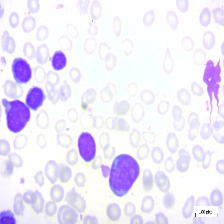
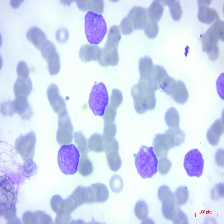
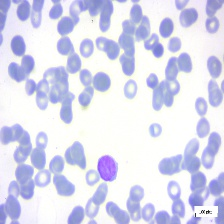
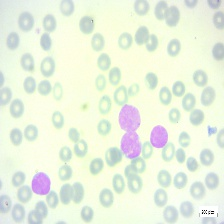

# Split images

In [ ]:
X, y = [], []

for img, label, _ in asset:
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

X_train_new = np.array(X_train).astype('float32')
X_test_new = np.array(X_test).astype('float32')

# Define functions

In [ ]:
def save_model(feat_ext, model, name, dir, X_test, y_test, only_record = True):
    import pickle
    import regex as re
    from datetime import datetime
    from sklearn.metrics import accuracy_score, confusion_matrix

    df_path = os.path.join(dir, 'model.csv')

    name += ' | {}'.format(datetime.now())
    model_path = os.path.join(dir, name)

    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_pred, y_test)
    test_confmat = confusion_matrix(y_pred, y_test)

    if not os.path.exists(df_path):
        df_model = pd.DataFrame({
            'datetime' : datetime.now(),
            'model' : [name],
            'test acc' : [test_acc],
            'test confmat' : [test_confmat],
            'binary file' : [model_path if not only_record else only_record]
        })

        df_model.to_csv(df_path, index = False)

    else:
        df_model = pd.read_csv(df_path)

        new_model = {
            'datetime' : datetime.now(),
            'model' : name,
            'test acc' : test_acc,
            'test confmat' : test_confmat,
            'binary file' : model_path if not only_record else only_record
        }

        df_model = df_model.append(new_model, ignore_index = True)

        df_model.to_csv(df_path, index = False)

    if not only_record:
        bin = {
            'feat_ext' : feat_ext,
            'model' : model
        }
        
        pickle.dump(bin, open(os.path.join(dir, name), 'wb'))

# Model training

## Extraction features

In [ ]:
extract_features = EfficientNetB0(weights = None, include_top = False, input_shape = (RESIZE, RESIZE, 3))

for layer in extract_features.layers:
    layer.trainable = False

extract_features.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

Hasil ekstraksi fitur

In [ ]:
extract_train = extract_features.predict(X_train_new)
extract_train.shape

(2279, 7, 7, 1280)

In [ ]:
extract_test = extract_features.predict(X_test_new)
extract_test.shape

(977, 7, 7, 1280)

Reshape fitur menjadi 1-D

In [ ]:
features_train = extract_train.reshape(extract_train.shape[0], -1)
features_train.shape

(2279, 62720)

In [ ]:
features_test = extract_test.reshape(extract_test.shape[0], -1)
features_test.shape

(977, 62720)

## SVM model

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel = 'poly')
svm_model.fit(features_train, y_train)

SVC(kernel='poly')

In [ ]:
y_pred = svm_model.predict(features_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(y_test, y_pred)

0.7635619242579325

In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 14,  85,  15,  37],
       [  1, 257,  37,   1],
       [  8,  28, 236,  17],
       [  1,   1,   0, 239]])

In [ ]:
save_model(extract_features, svm_model, 'B0 1', '/content/drive/MyDrive/Skripsi/Result/EfficientNet SVM', features_test, y_test, only_record = False)